# (11468) Shantanunaidu orbit determination test

In [1]:
import grss
prop = grss.prop
fit = grss.fit

In [2]:
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)

In [3]:
body_id = '11468'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
de_kernel = 440

In [4]:
add_gaia_obs = True
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias_lowres = True
deweight = True
eliminate = False
num_obs_per_night = 4
verbose = True
obs_df = fit.get_optical_obs(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias_lowres, deweight, eliminate, num_obs_per_night, verbose)
obs_df = fit.add_radar_obs(obs_df, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    gaia_dr = 'gaiafpr'
    obs_df = fit.add_gaia_obs(obs_df, t_min_tdb, t_max_tdb, gaia_dr, verbose)

Read in 1733 observations from the MPC.
	Filtered to 1733 observations that satisfy the time range and accepted observatory constraints.
Applying Eggl et al. (2020) debiasing scheme to the observations.
	Unknown star catalog: GSC
	Unknown star catalog: UNK
	No debiasing needed for 719 observations.
	Debiased 984 observations.
	No bias information for 30 observations.
Applying Vereš et al. (2017) weighting scheme to the observations.
	Using 1548 CCD observations with station-specific weight rules.
Applying sqrt(N/4) deweighting scheme.
	Deweighted 484 observations.
Read in 308 Gaia observations from gaiafpr
	Filtered to 308 observations that satisfy the time range constraints.


In [5]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, obs_df, init_cov, n_iter_max=n_iter_max, de_kernel=de_kernel, nongrav_info=nongrav_info)

In [6]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared


1			 0.432			 0.568			 1185.170			 0.291
2			 0.432			 0.568			 1185.539			 0.291
Converged without rejecting outliers. Starting outlier rejection now...
3			 0.397			 0.547			 1097.443			 0.270
4			 0.397			 0.547			 1097.330			 0.270
Converged after rejecting outliers. Rejected 6 out of 2041 optical observations.


In [7]:
fit_sim.print_summary()

Summary of the orbit fit calculations at iteration 4 (of 4):
RMS unweighted: 0.39727179245533933
RMS weighted: 0.5465100435962567
chi-squared: 1097.3304039786321
reduced chi-squared: 0.27001240255379727
square root of reduced chi-squared: 0.5196271764965698
--------------------------------------------------------------
Solution Time: MJD 57630.000 TDB = 2016-08-30 00:00:00.000 TDB
Solution Observation Arc: 15746.60 days (43.11 years)
--------------------------------------------------------------
Fitted Variable		Initial Value			Uncertainty			Fitted Value			Uncertainty			Change				Change (sigma)
e			1.66668735292e-01		2.26411771512e-09		1.66668735628e-01		2.27224873433e-09		+3.35722477596e-10		+0.148
q			2.56499149688e+00		2.93037414574e-09		2.56499149685e+00		2.94398381067e-09		-3.05027114678e-11		-0.010
tp			5.75112709974e+04		4.23197432606e-06		5.75112709980e+04		4.24900997371e-06		+5.77616447117e-07		+0.136
om			2.06374342935e+02		6.73526438176e-06		2.06374342905e+02		6.76817596102e

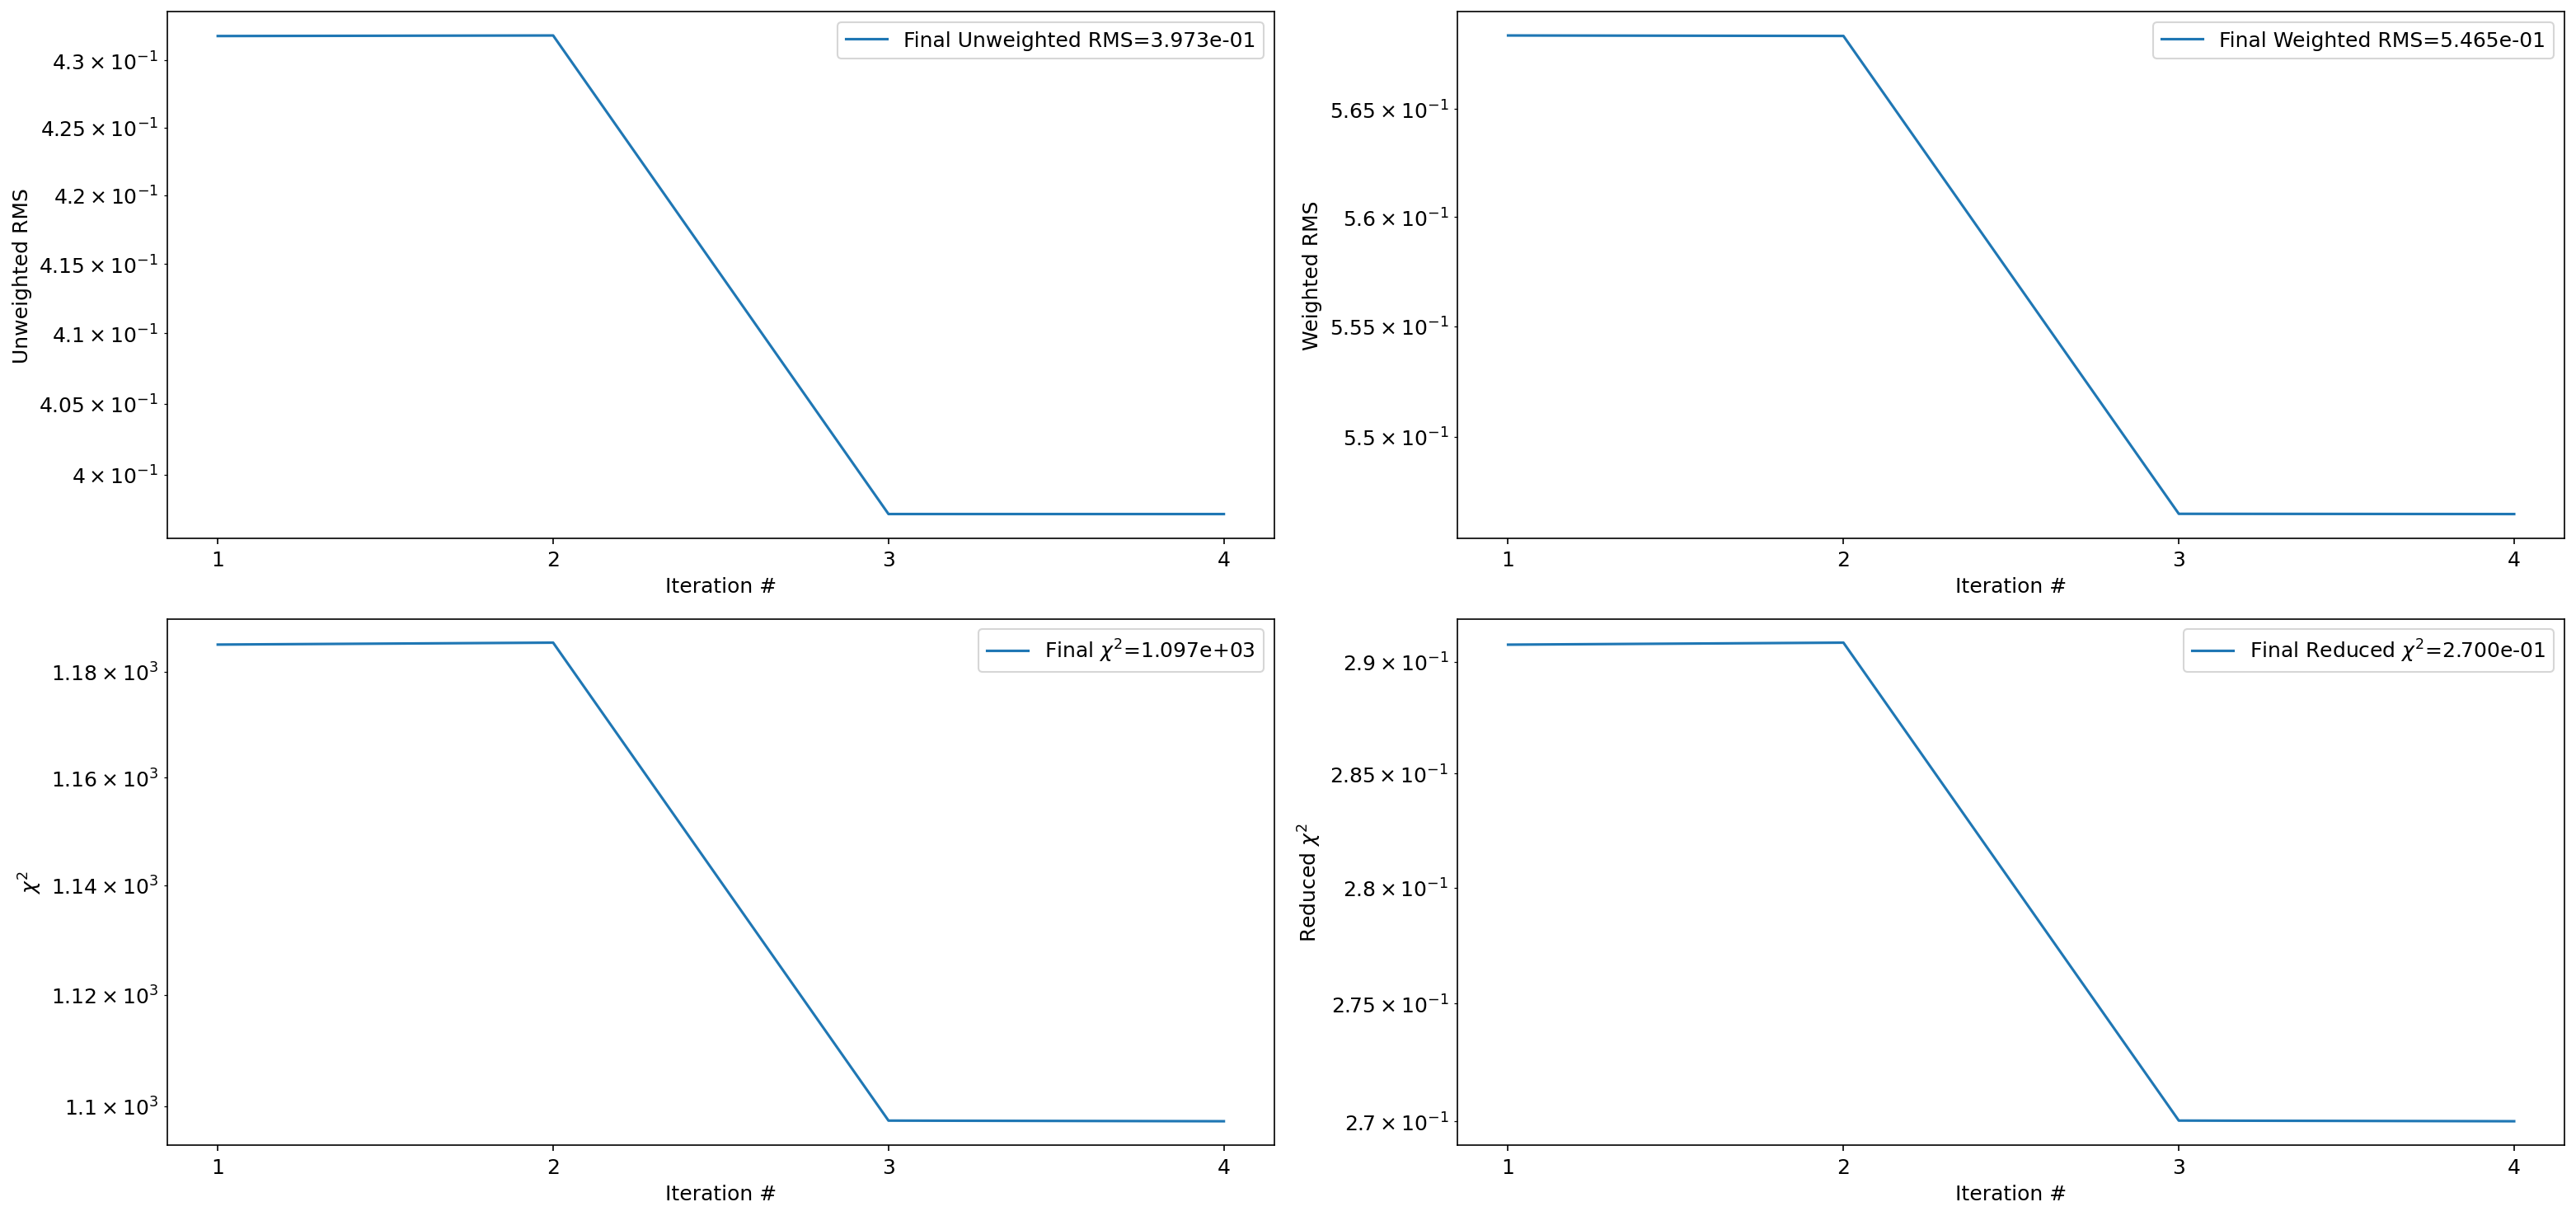

In [8]:
fit_sim.plot_summary(auto_close=True)

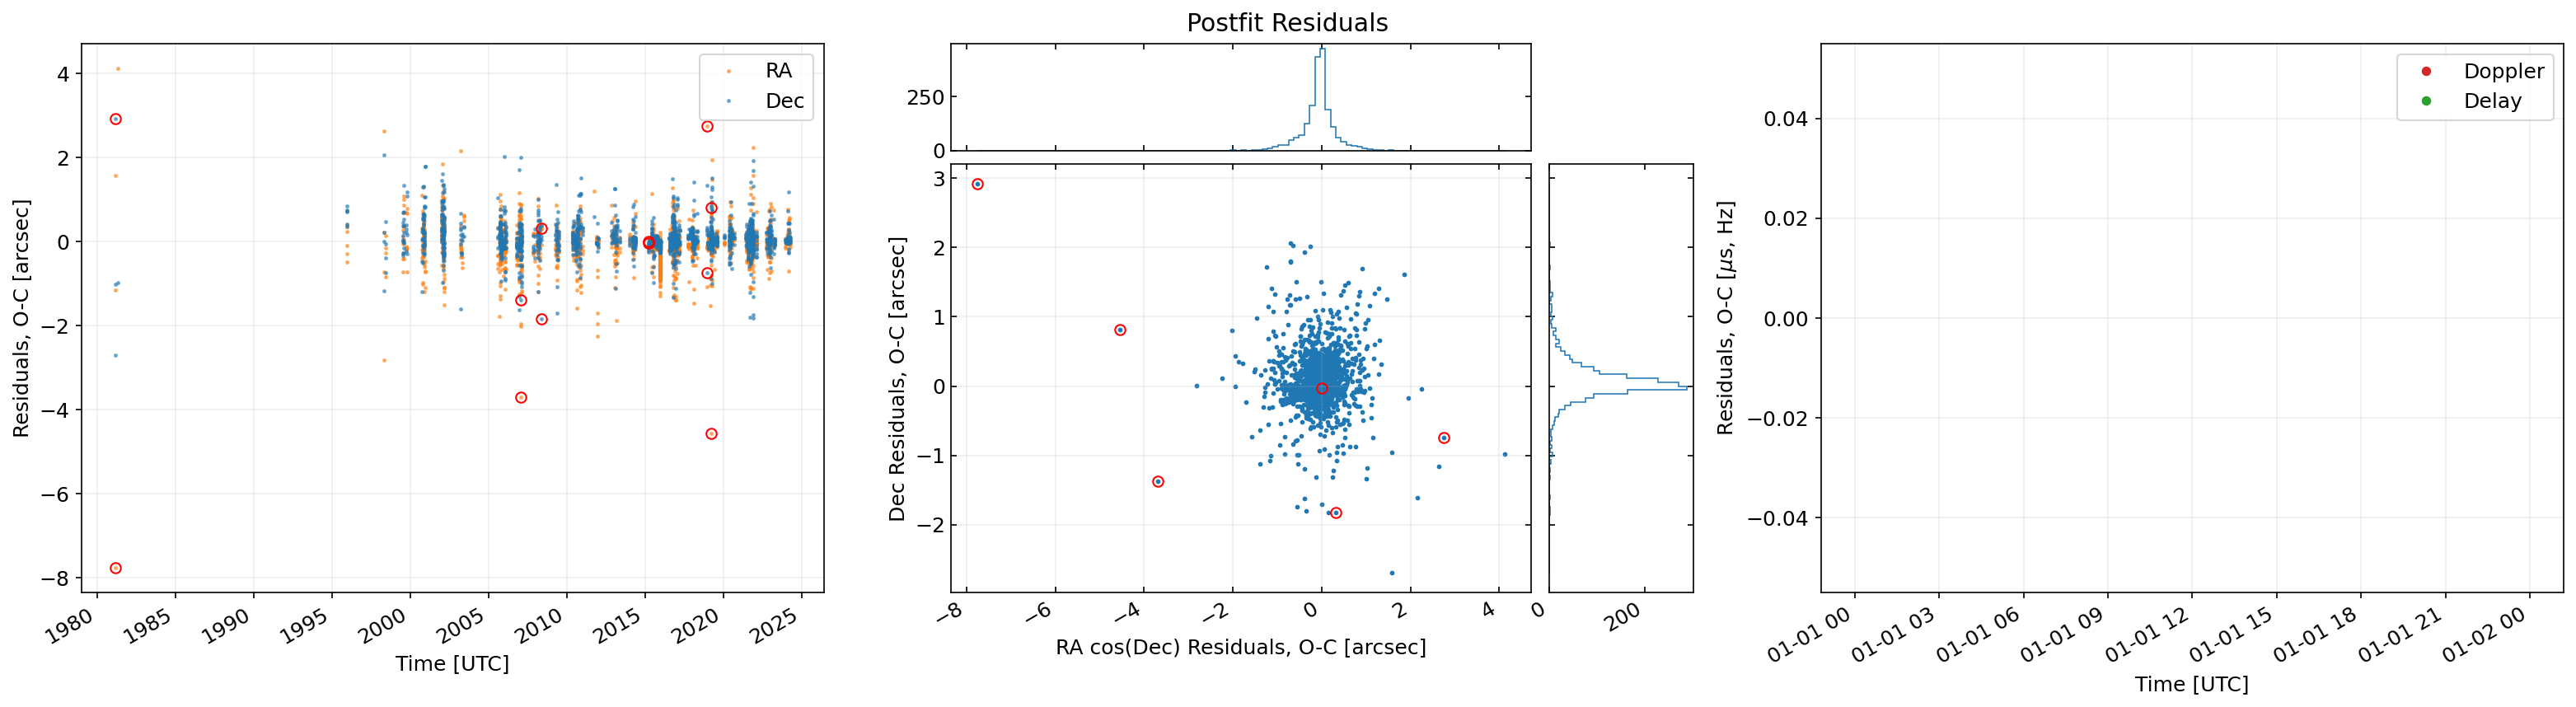

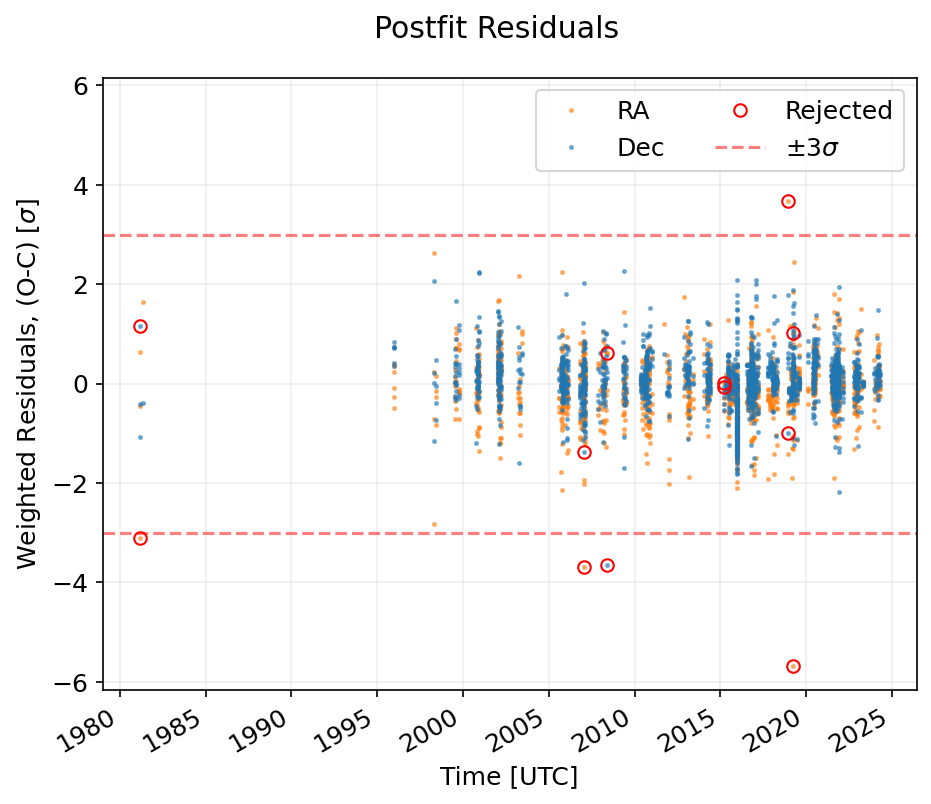

In [9]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [10]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 0.18
Mahalonobis distance between GRSS and JPL solution: 0.18
Bhattacharya distance between JPL and GRSS solution: 0.0000
Bhattacharya coefficient between JPL and GRSS solution: 1.0000


In [11]:
assert maha_dist_f < 5.0
assert maha_dist_0 < 5.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90